## Импортируем библиотеки

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import normaltest, shapiro, skewtest
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score

%matplotlib inline

In [34]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Вспомогательные функции

In [35]:
def prosmotr(data):
  pd.set_option('display.max_columns', 100) #Размеры таблицы
  pd.set_option('display.max_rows', 100)
  pd.set_option('precision', 2) #Регулируем количество знаков после запятой:
  print('~~~~Содержание данных~~~~\n', data.head())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Размеры данных~~~\n', data.shape)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Названия колонок~~~\n', data.columns)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Информация о данных~~~\n')
  print(data.info())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Наличие пропусков в данных~~~\n', data.isna().sum())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Количество типов в данных~~~')
  print(data.dtypes.value_counts())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  kateg = list(data.select_dtypes(include=['object']).columns) # Делаем список категориальных данных
  print('~~~Категориальные данные~~~~')
  print(kateg)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_float = list(data.select_dtypes(include=['float64'])) #Делаем список числовых данных float
  print('~~~Числове данные float~~~~')
  print(chislov_float)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_int = list(data.select_dtypes(include=['int64'])) #Делаем список числовых данных int
  print('~~~Числове данные int~~~~')
  print(chislov_int)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы int64)~~~\n', data.describe(include=['int64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы float64)~~~\n', data.describe(include=['float64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Cтатистика по нечисловым признакам object ~~~\n', data.describe(include=['object']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# функция для просмотра пропусков в данных

In [36]:
def values_table_null(data):
        # всего пропусков
        mis_val = data.isnull().sum()
        
        # процент пропусков
        mis_val_percent = 100 * data.isnull().sum() / len(data)
        
        # Делаем таблицу с получившимися результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименовать столбцы
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировка таблицы по проценту пропущенных по убыванию
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Выввод на печать сводную информацию
        print ("Выбранныей Вами данные " + str(data.shape[1]) + " колонок.\n"      
            "Из них " + str(mis_val_table_ren_columns.shape[0]) +
              " имеют пропуск")      

        return mis_val_table_ren_columns

## чистка данных

In [37]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

def df_fix_square_manual(df):
    df.loc[df['Square'] > 480, 'Square'] = df.loc[df['Square'] > 480, 'Square'] / 12
    return df

def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

# для категориальных признаков

In [38]:
#для преобразования категориальных признаков
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

# сравнение моделей

In [39]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

## построение графика после обучения

In [40]:
#построение графика после обучения
def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()

In [41]:
df_fix_house_year_manual(df)
df_fix_house_year_manual(test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.88,33.43,6.0,6,14.0,1972,3.10e-01,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.26,NaN,1.0,6,1.0,1977,7.58e-02,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.60,15.95,12.0,2,5.0,1909,0.00e+00,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.05,51.94,9.0,22,22.0,2007,1.02e-01,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.53,43.39,1.0,17,17.0,2017,7.22e-02,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.13,50.81,6.0,5,9.0,1973,1.70e-04,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.20,21.81,10.0,12,17.0,2017,7.12e-03,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.84,48.28,9.0,23,22.0,1989,9.08e-02,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.31,NaN,0.0,4,0.0,1977,7.22e-02,B,B,2,629,1,NaN,0,0,A


In [42]:
df_fix_square_manual(df)
df_fix_square_manual(test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.88,33.43,6.0,6,14.0,1972,3.10e-01,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.26,NaN,1.0,6,1.0,1977,7.58e-02,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.60,15.95,12.0,2,5.0,1909,0.00e+00,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.05,51.94,9.0,22,22.0,2007,1.02e-01,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.53,43.39,1.0,17,17.0,2017,7.22e-02,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.13,50.81,6.0,5,9.0,1973,1.70e-04,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.20,21.81,10.0,12,17.0,2017,7.12e-03,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.84,48.28,9.0,23,22.0,1989,9.08e-02,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.31,NaN,0.0,4,0.0,1977,7.22e-02,B,B,2,629,1,NaN,0,0,A


In [43]:
df_fix_room(df)
df_fix_room(test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_square_per_room_in_dr
0,725,58,2.0,49.88,33.43,6.0,6,14.0,1972,3.10e-01,B,B,11,2748,1,NaN,0,0,B,26.80
1,15856,74,2.0,69.26,NaN,1.0,6,1.0,1977,7.58e-02,B,B,6,1437,3,NaN,0,2,B,41.70
2,5480,190,1.0,13.60,15.95,12.0,2,5.0,1909,0.00e+00,B,B,30,7538,87,4702.0,5,5,B,13.60
3,15664,47,2.0,73.05,51.94,9.0,22,22.0,2007,1.02e-01,B,B,23,4583,3,NaN,3,3,B,36.66
4,14275,27,1.0,47.53,43.39,1.0,17,17.0,2017,7.22e-02,B,B,2,629,1,NaN,0,0,A,35.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.13,50.81,6.0,5,9.0,1973,1.70e-04,B,B,36,5992,0,NaN,1,1,B,22.89
4996,4695,1,1.0,40.20,21.81,10.0,12,17.0,2017,7.12e-03,B,B,1,264,0,NaN,0,1,B,33.54
4997,5783,12,3.0,77.84,48.28,9.0,23,22.0,1989,9.08e-02,B,B,74,19083,2,NaN,5,15,B,25.95
4998,4780,62,2.0,81.31,NaN,0.0,4,0.0,1977,7.22e-02,B,B,2,629,1,NaN,0,0,A,36.58


In [44]:
prepare_lifesquare(df)
prepare_lifesquare(test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.88,33.43,6.0,6,14.0,1972,3.10e-01,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.26,NaN,1.0,6,1.0,1977,7.58e-02,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.60,13.60,12.0,2,5.0,1909,0.00e+00,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.05,51.94,9.0,22,22.0,2007,1.02e-01,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.53,43.39,1.0,17,17.0,2017,7.22e-02,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.13,50.81,6.0,5,9.0,1973,1.70e-04,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.20,21.81,10.0,12,17.0,2017,7.12e-03,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.84,48.28,9.0,23,22.0,1989,9.08e-02,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.31,NaN,0.0,4,0.0,1977,7.22e-02,B,B,2,629,1,NaN,0,0,A


In [45]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.98,29.44,6.0,7,9.0,1969,8.90e-02,B,B,33,7976,5,NaN,0,11,B,184966.93
1,15053,41,3.0,65.68,40.05,8.0,7,9.0,1978,7.00e-05,B,B,46,10309,1,240.0,1,16,B,300009.45
2,4765,53,2.0,44.95,29.20,0.0,8,12.0,1968,4.96e-02,B,B,34,7759,0,229.0,1,3,B,220925.91
3,5809,58,2.0,53.35,52.73,9.0,8,17.0,1977,4.38e-01,B,B,23,5735,3,1084.0,0,5,B,175616.23
4,10783,99,1.0,39.65,23.78,7.0,11,12.0,1976,1.23e-02,B,B,35,5776,1,2078.0,2,4,B,150226.53


In [46]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.88,33.43,6.0,6,14.0,1972,0.31,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.26,NaN,1.0,6,1.0,1977,0.08,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.60,13.60,12.0,2,5.0,1909,0.00,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.05,51.94,9.0,22,22.0,2007,0.10,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.53,43.39,1.0,17,17.0,2017,0.07,B,B,2,629,1,NaN,0,0,A


In [47]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00,5000.00,5000.00,5000.00,3959.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,2623.00,5000.00,5000.00
mean,8412.60,51.28,1.91,56.45,35.98,5.98,8.63,12.60,1984.39,0.12,24.93,5406.90,8.26,1146.66,1.32,4.24
std,4832.67,44.18,0.84,19.09,17.18,9.95,5.48,6.79,18.57,0.12,17.53,4026.61,23.86,1044.74,1.48,4.78
min,1.00,0.00,0.00,1.38,0.33,0.00,1.00,0.00,1908.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00
25%,4221.75,21.00,1.00,41.91,23.09,1.00,4.00,9.00,1973.00,0.02,6.00,1564.00,0.00,325.00,0.00,1.00
50%,8320.50,37.00,2.00,52.92,32.89,6.00,7.00,12.00,1977.00,0.07,25.00,5285.00,2.00,900.00,1.00,3.00
75%,12598.25,77.00,2.00,66.29,45.07,9.00,12.00,17.00,2000.00,0.20,36.00,7287.00,5.00,1548.00,2.00,6.00
max,16795.00,212.00,17.00,223.45,168.73,620.00,78.00,99.00,2020.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00


In [48]:
prosmotr(df)

~~~~Содержание данных~~~~
       Id  DistrictId  Rooms  Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0   47.98       29.44            6.0      7   
1  15053          41    3.0   65.68       40.05            8.0      7   
2   4765          53    2.0   44.95       29.20            0.0      8   
3   5809          58    2.0   53.35       52.73            9.0      8   
4  10783          99    1.0   39.65       23.78            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   8.90e-02         B         B        33      7976   
1         9.0       1978   7.00e-05         B         B        46     10309   
2        12.0       1968   4.96e-02         B         B        34      7759   
3        17.0       1977   4.38e-01         B         B        23      5735   
4        12.0       1976   1.23e-02         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2    

## Целевой признак

In [49]:
df_p = df.drop('Price', axis=1)
y = df.Price.values

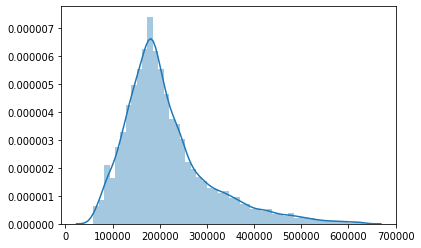

In [50]:
sns.distplot(y);

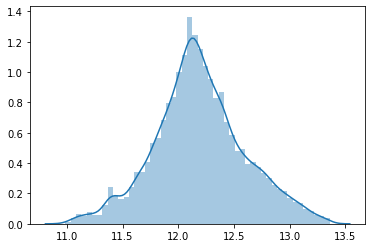

In [51]:
sns.distplot(np.log(y));

## Тест на нормальность и скошенность:

In [52]:
k2, p = normaltest(np.log(y))
print('normaly:', k2, p)

k2, p = skewtest(np.log(y))
print('skewness:', k2, p)

normaly: 27.344005657093007 1.154315732961165e-06
skewness: 4.390561978300804 1.1305808353326412e-05


In [53]:
a = np.random.normal(np.mean(np.log(y)), np.std(np.log(y)), size=len(y))

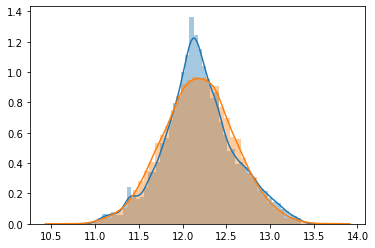

In [54]:
sns.distplot(np.log(y));
sns.distplot(a);

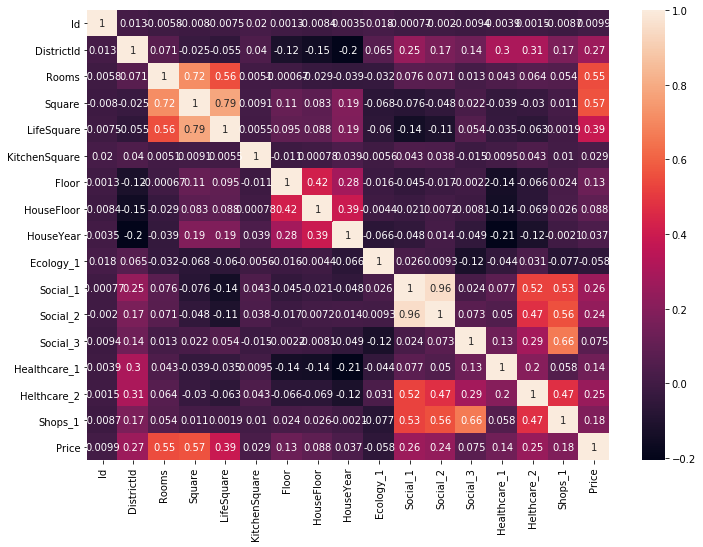

In [55]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.heatmap(df.corr(), annot=True, ax=ax);

попарное распределение

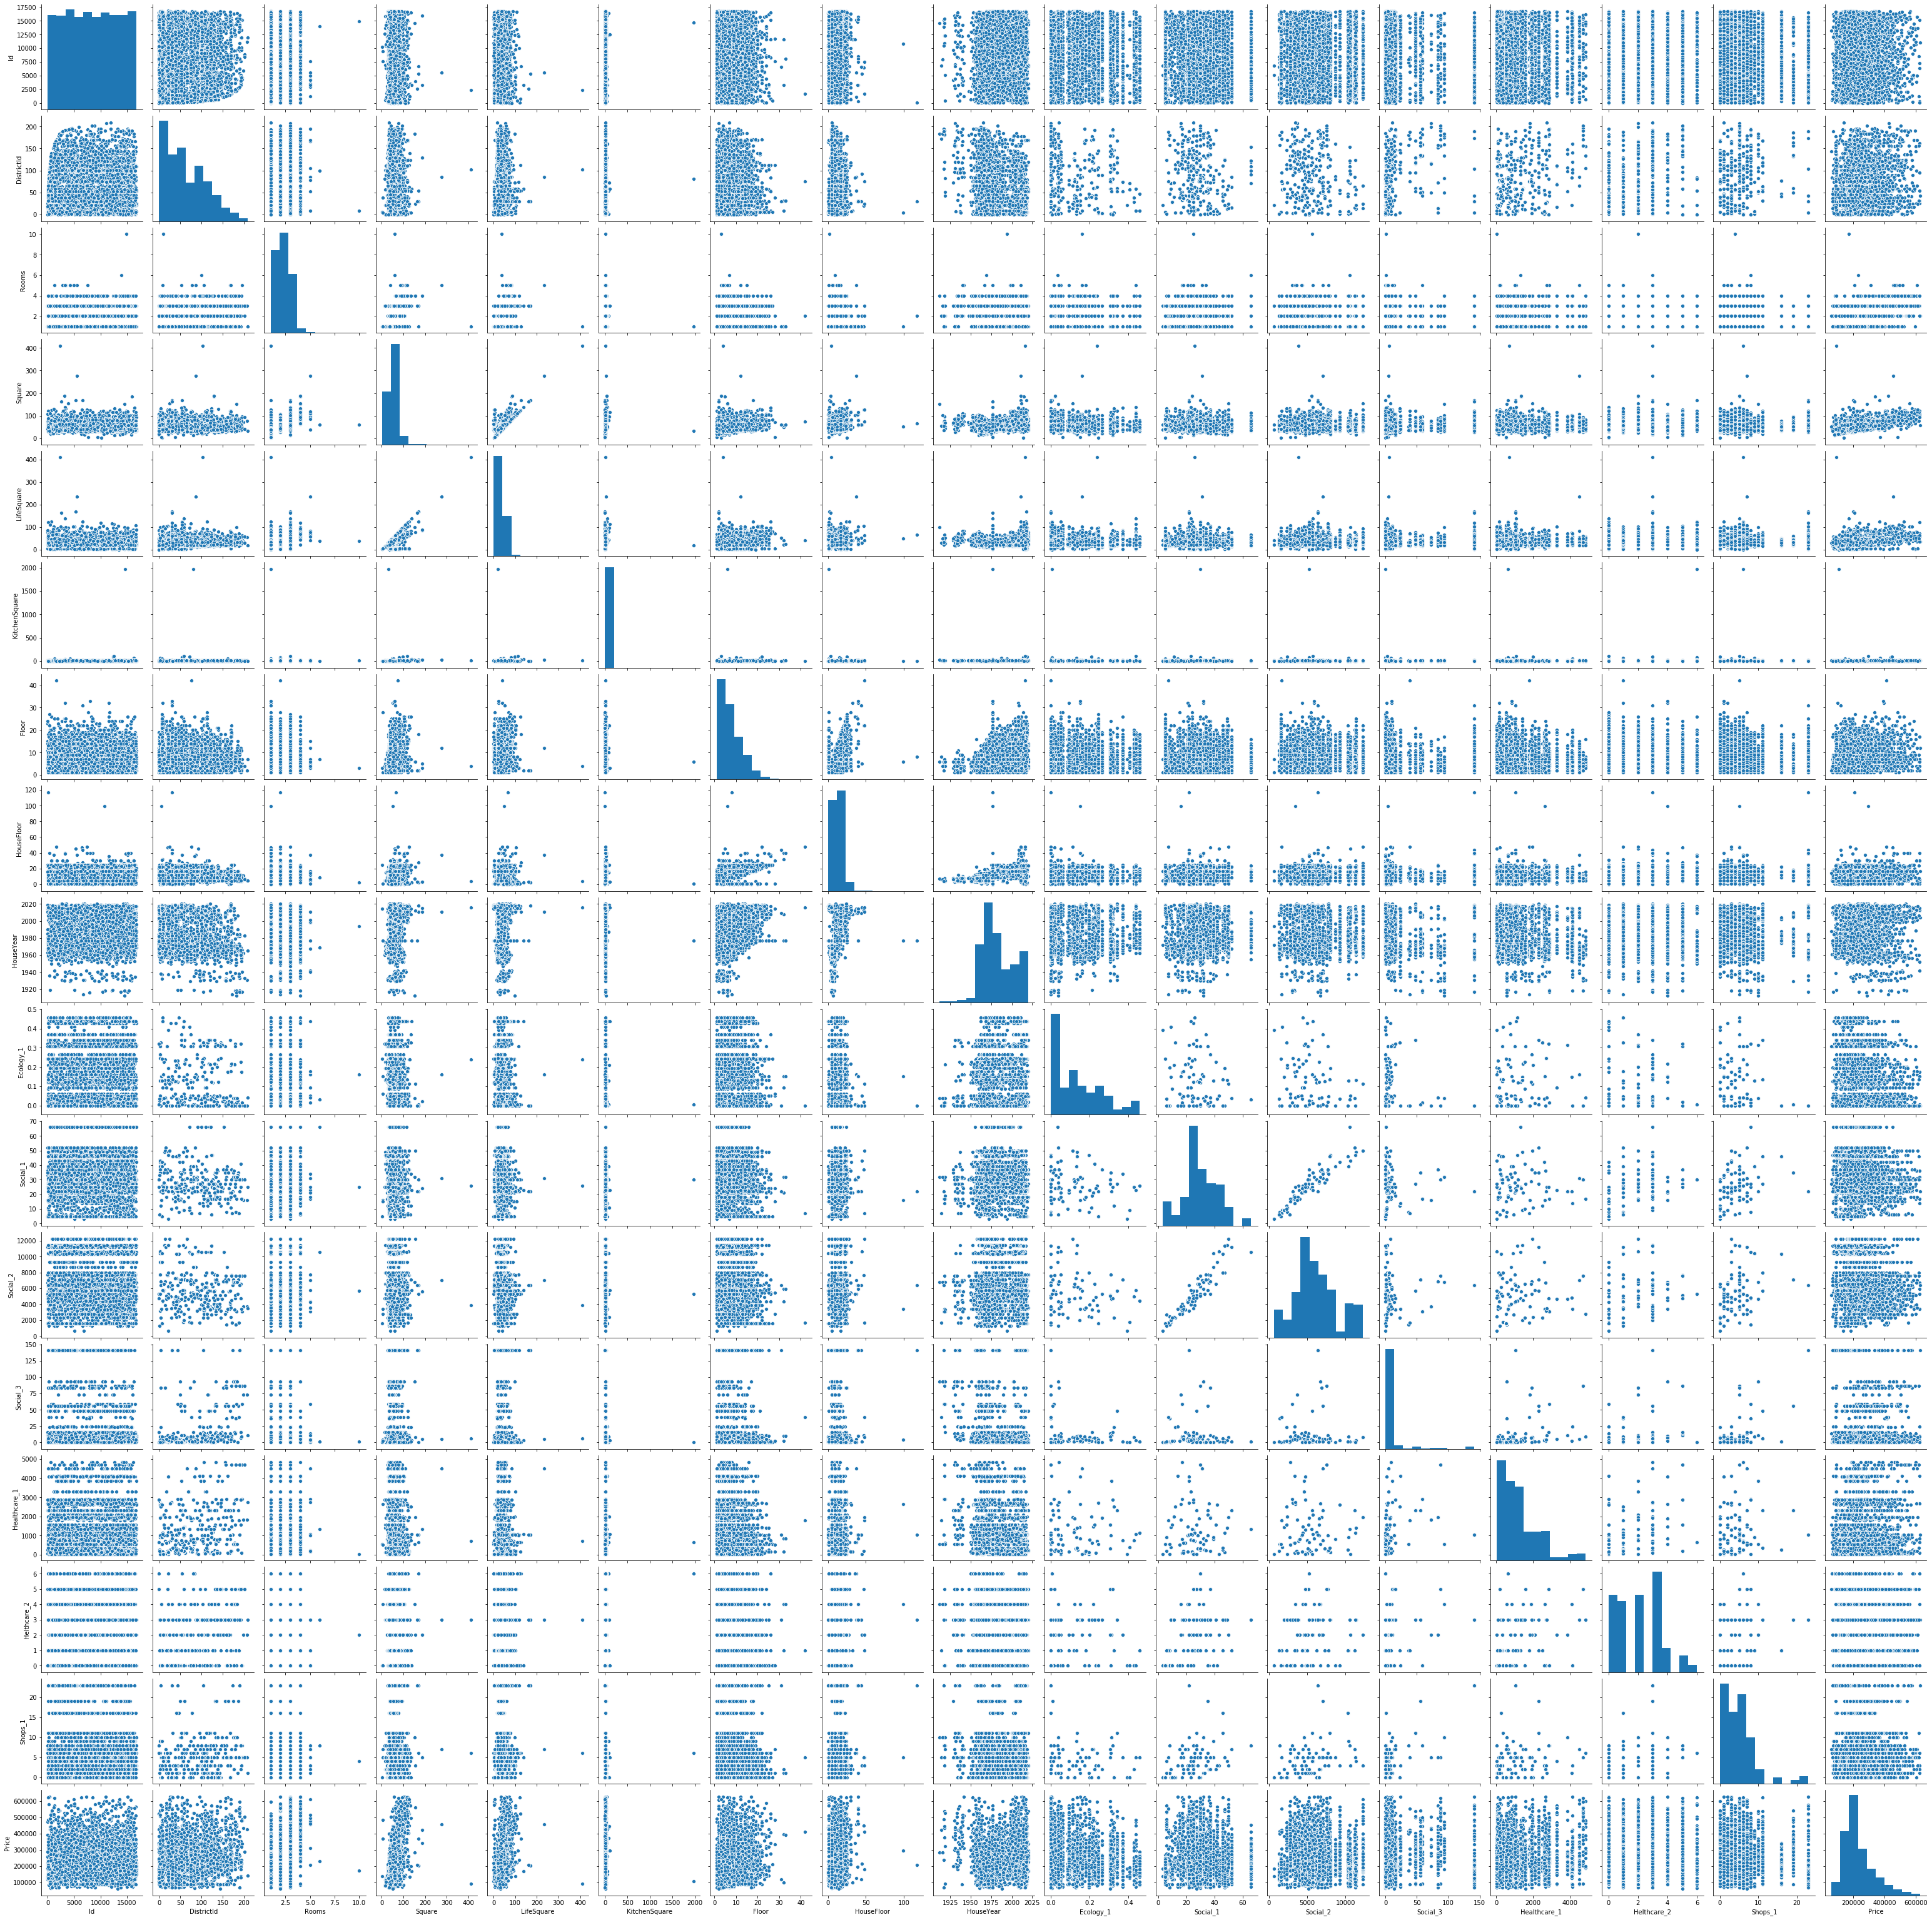

In [56]:
sns.pairplot(df.dropna());

пропуски

In [57]:
df_p[df_p.isnull().any(axis=1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,14038,35,2.0,47.98,29.44,6.0,7,9.0,1969,8.90e-02,B,B,33,7976,5,NaN,0,11,B
6,14549,154,2.0,62.25,37.16,7.0,3,5.0,1960,4.61e-01,B,B,20,4386,14,NaN,1,5,B
7,11993,74,2.0,80.31,NaN,0.0,14,0.0,1977,7.58e-02,B,B,6,1437,3,NaN,0,2,B
8,5172,1,2.0,64.51,NaN,1.0,9,17.0,1977,7.12e-03,B,B,1,264,0,NaN,0,1,B
9,8649,23,1.0,46.46,18.92,8.0,13,17.0,2014,7.58e-02,B,B,6,1437,3,NaN,0,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,14333,150,3.0,78.25,49.39,10.0,5,16.0,1976,3.00e-01,B,B,52,10311,6,NaN,1,9,B
9993,48,13,3.0,80.63,48.90,10.0,11,14.0,1999,9.08e-02,B,B,74,19083,2,NaN,5,15,B
9994,4158,23,2.0,64.86,NaN,1.0,17,17.0,1977,7.58e-02,B,B,6,1437,3,NaN,0,2,B
9996,6159,18,1.0,41.52,20.54,9.0,13,13.0,2000,0.00e+00,B,B,30,5562,0,NaN,0,5,A


In [58]:
values_table_null(df_p)

Выбранныей Вами данные 19 колонок.
Из них 2 имеют пропуск


,Missing Values,% of Total Values
Healthcare_1,4798,48.0
LifeSquare,2113,21.1


In [59]:
values_table_null(test)

Выбранныей Вами данные 19 колонок.
Из них 2 имеют пропуск


,Missing Values,% of Total Values
Healthcare_1,2377,47.5
LifeSquare,1041,20.8


Выделяем категориальные признаки

In [60]:
categorical = df_p.select_dtypes(include = ["object"]).columns
categorical

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

Выделяем числовые признаки

In [61]:
numerical = df_p.select_dtypes(exclude = ["object"]).columns
numerical

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1'],
      dtype='object')

Подготавливаем числовые признаки

In [62]:
numerical = numerical.drop("Id")
numerical = numerical.drop("LifeSquare")
numerical = numerical.drop("Healthcare_1")
numerical

Index(['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Helthcare_2', 'Shops_1'],
      dtype='object')

In [63]:
train_numerical = df_p[numerical]
train_numerical.head(3)

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,35,2.0,47.98,6.0,7,9.0,1969,8.90e-02,33,7976,5,0,11
1,41,3.0,65.68,8.0,7,9.0,1978,7.00e-05,46,10309,1,1,16
2,53,2.0,44.95,0.0,8,12.0,1968,4.96e-02,34,7759,0,1,3


In [64]:
train_numerical.isnull().values.sum()

0

нет пропусков

Нормализуем получившиеся данные

In [65]:
mean = train_numerical.mean(axis=0)
std = train_numerical.std(axis=0)
train_numerical -= mean
train_numerical /= std

In [66]:
train_numerical.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,-0.35,0.13,-0.42,-9.57e-03,-0.29,-0.53,-0.86,-0.25,0.47,0.65,-0.13,-0.88,1.41
1,-0.22,1.32,0.49,6.05e-02,-0.29,-0.53,-0.37,-1.00,1.22,1.24,-0.30,-0.21,2.45
2,0.06,0.13,-0.58,-2.20e-01,-0.10,-0.09,-0.92,-0.58,0.53,0.60,-0.34,-0.21,-0.26
3,0.17,0.13,-0.15,9.55e-02,-0.10,0.65,-0.43,2.68,-0.10,0.10,-0.21,-0.88,0.16
4,1.11,-1.06,-0.85,2.54e-02,0.47,-0.09,-0.48,-0.89,0.59,0.11,-0.30,0.46,-0.05


In [67]:
train_categorical = df_p[categorical]
train_categorical.describe()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [74]:
train_categorical.Ecology_2, Ecology_2Ref = SeriesFactorizer(df.Ecology_2)

{0: 'B', 1: 'A'}


In [75]:
train_categorical.Ecology_3, Ecology_3Ref = SeriesFactorizer(df.Ecology_3)

{0: 'B', 1: 'A'}


In [76]:
train_categorical[:5]

,Ecology_2,Ecology_3,Shops_2
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


 делаем тренировочные данные

In [78]:
x_train = pd.concat([train_numerical, train_categorical], axis = 1)
x_train.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2,Ecology_3,Shops_2
0,-0.35,0.13,-0.42,-9.57e-03,-0.29,-0.53,-0.86,-0.25,0.47,0.65,-0.13,-0.88,1.41,0,0,0
1,-0.22,1.32,0.49,6.05e-02,-0.29,-0.53,-0.37,-1.00,1.22,1.24,-0.30,-0.21,2.45,0,0,0
2,0.06,0.13,-0.58,-2.20e-01,-0.10,-0.09,-0.92,-0.58,0.53,0.60,-0.34,-0.21,-0.26,0,0,0
3,0.17,0.13,-0.15,9.55e-02,-0.10,0.65,-0.43,2.68,-0.10,0.10,-0.21,-0.88,0.16,0,0,0
4,1.11,-1.06,-0.85,2.54e-02,0.47,-0.09,-0.48,-0.89,0.59,0.11,-0.30,0.46,-0.05,0,0,0


In [79]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  float64
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   KitchenSquare  10000 non-null  float64
 4   Floor          10000 non-null  float64
 5   HouseFloor     10000 non-null  float64
 6   HouseYear      10000 non-null  float64
 7   Ecology_1      10000 non-null  float64
 8   Social_1       10000 non-null  float64
 9   Social_2       10000 non-null  float64
 10  Social_3       10000 non-null  float64
 11  Helthcare_2    10000 non-null  float64
 12  Shops_1        10000 non-null  float64
 13  Ecology_2      10000 non-null  int64  
 14  Ecology_3      10000 non-null  int64  
 15  Shops_2        10000 non-null  int64  
dtypes: float64(13), int64(3)
memory usage: 1.2 MB


In [80]:
y_train = df['Price']
y_train[:10]

0    184966.93
1    300009.45
2    220925.91
3    175616.23
4    150226.53
5    215898.45
6    296021.20
7    221244.16
8    229102.80
9     95380.22
Name: Price, dtype: float64

In [81]:
x_train[:10]

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2,Ecology_3,Shops_2
0,-0.35,0.13,-0.42,-9.57e-03,-0.29,-0.53,-0.86,-0.25,0.47,0.65,-0.13,-0.88,1.41,0,0,0
1,-0.22,1.32,0.49,6.05e-02,-0.29,-0.53,-0.37,-1.00,1.22,1.24,-0.30,-0.21,2.45,0,0,0
2,0.06,0.13,-0.58,-2.20e-01,-0.10,-0.09,-0.92,-0.58,0.53,0.60,-0.34,-0.21,-0.26,0,0,0
3,0.17,0.13,-0.15,9.55e-02,-0.10,0.65,-0.43,2.68,-0.10,0.10,-0.21,-0.88,0.16,0,0,0
4,1.11,-1.06,-0.85,2.54e-02,0.47,-0.09,-0.48,-0.89,0.59,0.11,-0.30,0.46,-0.05,0,0,0
5,0.20,1.32,1.24,2.01e-01,-0.67,0.65,1.42,1.60,0.59,0.59,-0.17,-0.88,0.37,0,0,0
6,2.38,0.13,0.31,2.54e-02,-1.05,-1.12,-1.35,2.87,-0.27,-0.24,0.25,-0.21,0.16,0,0,0
7,0.54,0.13,1.24,-2.20e-01,1.04,-1.86,-0.43,-0.36,-1.07,-0.98,-0.21,-0.88,-0.46,0,0,0
8,-1.13,0.13,0.43,-1.85e-01,0.09,0.65,-0.43,-0.94,-1.35,-1.27,-0.34,-0.88,-0.67,0,0,0
9,-0.63,-1.06,-0.50,6.05e-02,0.85,0.65,1.58,-0.36,-1.07,-0.98,-0.21,-0.88,-0.46,0,0,0


In [86]:
X_train.shape

(7000, 16)

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [93]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [91]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

ModuleNotFoundError: No module named 'xgboost'